Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# For this to work, use:
# Keras 2.3.1
# TensorFlow 1.15.2
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 14.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 12.8 MB/s 
     |████████████████████████████████| 101 kB 13.6 MB/s 
     |████████████████████████████████| 596 kB 55.4 MB/s 
     |████████████████████████████████| 6.6 MB 77.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=7e9b3cdb0620dd6fb062f92ba5892588c1251e0c293230745751ec513d7ead69
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1Y2gfhNgbGX7pA0FkA2vbOxdoSmNJVHIK'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1AGW9cRPwBmeJqOo3WXPPcNckrX4jMcIn'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [3]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13052
Number of dev sentences:  3263
Number of test sentences:  27625
Number of words in the training dataset:  13860
Number of words in the dev dataset:  6360
Number of words in the test dataset:  21696
Tags in the training dataset: ['B-test', 'O', 'I-problem', 'B-treatment', 'I-treatment', 'B-problem', 'I-test']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['B-test', 'O', 'I-problem', 'B-treatment', 'I-treatment', 'B-problem', 'I-test']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['B-test', 'O', 'I-problem', 'B-treatment', 'I-treatment', 'B-problem', 'I-test']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 10707,She,O
1,Sentence: 10707,had,O
2,Sentence: 10707,normal,O
3,Sentence: 10707,comprehension,O
4,Sentence: 10707,.,O
5,Sentence: 7349,Scott,O
6,Sentence: 7349,Robert,O
7,Sentence: 7349,NP,O
8,Sentence: 7349,80-AUM,O
9,Sentence: 7349,2017-06-29,O


In [4]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Last', 'O'),
 ('menstrual', 'O'),
 ('period', 'O'),
 ('2009-02-21', 'O'),
 ('.', 'O')]

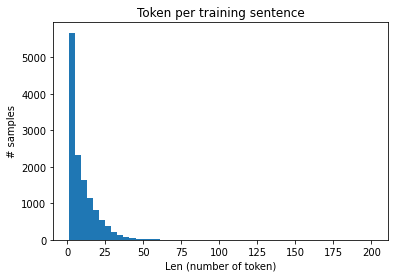

In [5]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

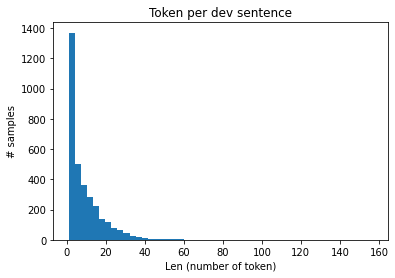

In [6]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

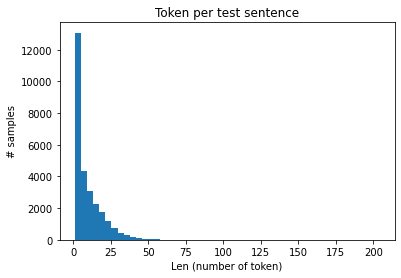

In [7]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [8]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

28244
04/12/1998
3
I-treatment


In [9]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [10]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9962)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13052
Points in y_train before removal: 13052
Points in X_train before removal: 50
Points in y_train before removal: 50


In [11]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [12]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[6005, 14392, 16382, 21202, 988]
[1, 1, 1, 1, 1]
[15768, 10477, 17704, 18891, 3576, 17774, 4734, 25794, 13323, 21614, 9586, 25383, 2542, 15667]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[15190, 5693, 19676]
[1, 1, 1]
28244
3
I-problem
Sinequan
28388
7


In [13]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 1.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[6005, 14392, 16382, 21202, 988]
[1, 1, 1, 1, 1]
[15768, 10477, 17704, 18891, 3576, 17774, 4734, 25794, 13323, 21614, 9586, 25383, 2542, 15667]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[15190, 5693, 19676]
[1, 1, 1]
28244
3
I-problem
Sinequan
28388
7


In [14]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [15]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [16]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

In [17]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 64:
    TRAIN_BATCH_SIZE = 64
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 64:
    VALID_BATCH_SIZE = 64
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [18]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [19]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [20]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [' '.join([idx2word[word] for word in sentence]) for sentence in augmented_X_train]
  X_dev_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_dev]
  X_test_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [21]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.476820230484009
Training loss epoch: 1.3599637746810913
Training accuracy epoch: 0.6200000000000001
Validating model...
Validation Loss: 0.6522508345398248
Validation Accuracy: 0.8329637410519762
Training epoch: 2
Training loss per 100 training steps: 0.40422648191452026
Training loss epoch: 0.5071892231702805
Training accuracy epoch: 0.8800000000000001
Validating model...
Validation Loss: 0.53961428064926
Validation Accuracy: 0.8400200357920946
Training epoch: 3
Training loss per 100 training steps: 0.2070293426513672
Training loss epoch: 0.27637484222650527
Training accuracy epoch: 0.9199999999999999
Validating model...
Validation Loss: 0.5457901165765875
Validation Accuracy: 0.8446156240273887
Training epoch: 4
Training loss per 100 training steps: 0.42461317777633667
Training loss epoch: 0.21408246979117393
Training accuracy epoch: 0.9199999999999999
Validating model...
Validation Loss: 0.48708460845199286
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48689717720090236
Validation Accuracy: 0.85375998616757
Validation duration: 2.0426324999999994 minutes
F1-score (test): 36.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.62      0.34      0.44      2464
   treatment       0.78      0.32      0.45      1244

   micro avg       0.66      0.25      0.37      4878
   macro avg       0.47      0.22      0.30      4878
weighted avg       0.51      0.25      0.34      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7754828929901123
Training loss epoch: 1.0438359439373017
Training accuracy epoch: 0.7
Validating model...
Validation Loss: 0.6861925914007074
Validation Accuracy: 0.832954014939309
Training epoch: 2
Training loss per 100 training steps: 0.6635000705718994
Training loss epoch: 0.38824249505996705
Training accuracy epoch: 0.8400000000000001
Validating model...
Validation Loss: 0.5557782977235084
Validation Accuracy: 0.8299000155617802
Training epoch: 3
Training loss per 100 training steps: 0.20010514557361603
Training loss epoch: 0.16276527792215348
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.5297897098695531
Validation Accuracy: 0.8391155073140367
Training epoch: 4
Training loss per 100 training steps: 0.17843608558177948
Training loss epoch: 0.0662461370229721
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.6004808685358833
Validation Accuracy: 0.837860838

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5629930374109082
Validation Accuracy: 0.8301372304087624
Validation duration: 2.03452625 minutes
F1-score (test): 8.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.76      0.06      0.10      2464
   treatment       0.67      0.06      0.10      1244

   micro avg       0.73      0.04      0.08      4878
   macro avg       0.48      0.04      0.07      4878
weighted avg       0.56      0.04      0.08      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2407524585723877
Training loss epoch: 1.2435658812522887
Training accuracy epoch: 0.64
Validating model...
Validation Loss: 0.6566241085529327
Validation Accuracy: 0.8329783302209773
Training epoch: 2
Training loss per 100 training steps: 0.9101551175117493
Training loss epoch: 0.5336910098791122
Training accuracy epoch: 0.82
Validating model...
Validation Loss: 0.5296735973919139
Validation Accuracy: 0.8602552131963896
Training epoch: 3
Training loss per 100 training steps: 0.4090327322483063
Training loss epoch: 0.1726834826171398
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.5012655810398214
Validation Accuracy: 0.8541277622159975
Training epoch: 4
Training loss per 100 training steps: 0.03622224181890488
Training loss epoch: 0.08318502642214298
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4998128069382088
Validation Accuracy: 0.8587233504512917
Training epoch: 5
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4699800376331917
Validation Accuracy: 0.8695861209914183
Validation duration: 2.03374315 minutes
F1-score (test): 44.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.76      0.43      0.55      2464
   treatment       0.82      0.36      0.50      1244

   micro avg       0.78      0.31      0.44      4878
   macro avg       0.53      0.26      0.35      4878
weighted avg       0.59      0.31      0.41      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.111098289489746
Training loss epoch: 1.114192581176758
Training accuracy epoch: 0.6
Validating model...
Validation Loss: 0.7215262032022663
Validation Accuracy: 0.7977357609710551
Training epoch: 2
Training loss per 100 training steps: 0.2685074508190155
Training loss epoch: 0.437041711807251
Training accuracy epoch: 0.82
Validating model...
Validation Loss: 0.5984920643123925
Validation Accuracy: 0.8173776455026455
Training epoch: 3
Training loss per 100 training steps: 0.04607139155268669
Training loss epoch: 0.161624488979578
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.5065947636669758
Validation Accuracy: 0.8584315670712729
Training epoch: 4
Training loss per 100 training steps: 0.04988231137394905
Training loss epoch: 0.043400542438030244
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5633656701036528
Validation Accuracy: 0.8556790771864301
Training epoch: 5
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5366815251332743
Validation Accuracy: 0.847265448565944
Validation duration: 2.0450872500000004 minutes
F1-score (test): 25.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.72      0.23      0.35      2464
   treatment       0.94      0.14      0.24      1244

   micro avg       0.76      0.15      0.25      4878
   macro avg       0.55      0.12      0.20      4878
weighted avg       0.60      0.15      0.24      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- T

Training epoch: 1
Training loss per 100 training steps: 1.8667614459991455
Training loss epoch: 1.078909796476364
Training accuracy epoch: 0.6599999999999999
Validating model...
Validation Loss: 0.6405360301335653
Validation Accuracy: 0.8329880563336446
Training epoch: 2
Training loss per 100 training steps: 0.2286539375782013
Training loss epoch: 0.3651049941778183
Training accuracy epoch: 0.9
Validating model...
Validation Loss: 0.4985980899894939
Validation Accuracy: 0.849823957360722
Training epoch: 3
Training loss per 100 training steps: 0.3237009644508362
Training loss epoch: 0.16892133355140687
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.4709080595011805
Validation Accuracy: 0.8599585667600373
Training epoch: 4
Training loss per 100 training steps: 0.1668429970741272
Training loss epoch: 0.05552993491292
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.488227529852998
Validation Accuracy: 0.8679096638655461
Training epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48626507115032935
Validation Accuracy: 0.850242773261066
Validation duration: 2.0427917499999997 minutes
F1-score (test): 28.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.78      0.20      0.32      2464
   treatment       0.88      0.27      0.41      1244

   micro avg       0.82      0.17      0.28      4878
   macro avg       0.55      0.16      0.24      4878
weighted avg       0.62      0.17      0.26      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- T

Training epoch: 1
Training loss per 100 training steps: 1.6066945791244507
Training loss epoch: 0.9829492330551147
Training accuracy epoch: 0.7
Validating model...
Validation Loss: 0.6645982177818522
Validation Accuracy: 0.7802579365079364
Training epoch: 2
Training loss per 100 training steps: 0.39664599299430847
Training loss epoch: 0.37877110838890077
Training accuracy epoch: 0.8800000000000001
Validating model...
Validation Loss: 0.5610394805085426
Validation Accuracy: 0.7968506847183318
Training epoch: 3
Training loss per 100 training steps: 0.15206003189086914
Training loss epoch: 0.11085180677473545
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.5117340990725685
Validation Accuracy: 0.8535198801742919
Training epoch: 4
Training loss per 100 training steps: 0.03236023336648941
Training loss epoch: 0.06304421685636044
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.5078980744469399
Validation Accuracy: 0.857191

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5037777454299094
Validation Accuracy: 0.8606956089092141
Validation duration: 2.032773933333332 minutes
F1-score (test): 36.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.01      0.01      1170
        test       0.69      0.33      0.45      2464
   treatment       0.87      0.28      0.43      1244

   micro avg       0.73      0.24      0.36      4878
   macro avg       0.78      0.21      0.30      4878
weighted avg       0.75      0.24      0.34      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.3903717994689941
Training loss epoch: 0.9750090003013611
Training accuracy epoch: 0.7399999999999999
Validating model...
Validation Loss: 0.5891819327485328
Validation Accuracy: 0.834198957360722
Training epoch: 2
Training loss per 100 training steps: 0.3264021873474121
Training loss epoch: 0.27649697959423064
Training accuracy epoch: 0.9
Validating model...
Validation Loss: 0.5013627906640371
Validation Accuracy: 0.870662153750389
Training epoch: 3
Training loss per 100 training steps: 0.08356199413537979
Training loss epoch: 0.09078303128480911
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.530612466674225
Validation Accuracy: 0.8679291160908807
Training epoch: 4
Training loss per 100 training steps: 0.07380134612321854
Training loss epoch: 0.028090164251625537
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6719131539849674
Validation Accuracy: 0.8602454870837224
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5254352911961852
Validation Accuracy: 0.8553355422877146
Validation duration: 2.0494854833333305 minutes
F1-score (test): 33.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.72      0.34      0.46      2464
   treatment       0.93      0.16      0.27      1244

   micro avg       0.75      0.21      0.33      4878
   macro avg       0.55      0.17      0.25      4878
weighted avg       0.60      0.21      0.30      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1024489402770996
Training loss epoch: 1.1128372967243194
Training accuracy epoch: 0.6399999999999999
Validating model...
Validation Loss: 0.7322294010835535
Validation Accuracy: 0.7870224478680361
Training epoch: 2
Training loss per 100 training steps: 0.8962873220443726
Training loss epoch: 0.43620221614837645
Training accuracy epoch: 0.86
Validating model...
Validation Loss: 0.5850459641101313
Validation Accuracy: 0.8329929193899781
Training epoch: 3
Training loss per 100 training steps: 0.27735862135887146
Training loss epoch: 0.20371223986148834
Training accuracy epoch: 0.96
Validating model...
Validation Loss: 0.5349648106916278
Validation Accuracy: 0.8492063492063492
Training epoch: 4
Training loss per 100 training steps: 0.052081383764743805
Training loss epoch: 0.08780026473104954
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.5211784629260793
Validation Accuracy: 0.8574686819172114
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5010442150998171
Validation Accuracy: 0.866333559168925
Validation duration: 2.0583627833333327 minutes
F1-score (test): 44.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.72      0.46      0.56      2464
   treatment       0.67      0.38      0.48      1244

   micro avg       0.71      0.33      0.45      4878
   macro avg       0.46      0.28      0.35      4878
weighted avg       0.54      0.33      0.41      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9066162109375
Training loss epoch: 1.0575971275568008
Training accuracy epoch: 0.68
Validating model...
Validation Loss: 0.6415938553856868
Validation Accuracy: 0.8329588779956427
Training epoch: 2
Training loss per 100 training steps: 0.05729638785123825
Training loss epoch: 0.24377467036247252
Training accuracy epoch: 0.9199999999999999
Validating model...
Validation Loss: 0.49680626158620794
Validation Accuracy: 0.8498190943043884
Training epoch: 3
Training loss per 100 training steps: 0.10489492118358612
Training loss epoch: 0.10085061937570572
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4547065572411406
Validation Accuracy: 0.8642477824463118
Training epoch: 4
Training loss per 100 training steps: 0.09124214947223663
Training loss epoch: 0.03335364423692226
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5816920463945351
Validation Accuracy: 0.8547210550887021
Training epoch: 5
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48427171801665314
Validation Accuracy: 0.8531451134823848
Validation duration: 2.036891949999995 minutes
F1-score (test): 34.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.65      0.33      0.44      2464
   treatment       0.81      0.23      0.35      1244

   micro avg       0.68      0.23      0.34      4878
   macro avg       0.49      0.19      0.26      4878
weighted avg       0.53      0.23      0.31      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 50
Points in y_train after augmentation: 50
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9156869649887085
Training loss epoch: 1.0920961618423461
Training accuracy epoch: 0.64
Validating model...
Validation Loss: 0.6609980878876704
Validation Accuracy: 0.8338828586990351
Training epoch: 2
Training loss per 100 training steps: 0.28277450799942017
Training loss epoch: 0.40244958400726316
Training accuracy epoch: 0.8800000000000001
Validating model...
Validation Loss: 0.5929388339612999
Validation Accuracy: 0.8489145658263305
Training epoch: 3
Training loss per 100 training steps: 0.26902085542678833
Training loss epoch: 0.2011227123439312
Training accuracy epoch: 0.96
Validating model...
Validation Loss: 0.4965324442760617
Validation Accuracy: 0.863027155306567
Training epoch: 4
Training loss per 100 training steps: 0.028596635907888412
Training loss epoch: 0.08007164187729358
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.5187262512889563
Validation Accuracy: 0.8617773498288205
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5255623045204966
Validation Accuracy: 0.8534547552506775
Validation duration: 2.0463356833333366 minutes
F1-score (test): 29.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.88      0.24      0.38      2464
   treatment       0.97      0.22      0.36      1244

   micro avg       0.91      0.18      0.30      4878
   macro avg       0.62      0.15      0.25      4878
weighted avg       0.69      0.18      0.28      4878



In [22]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.893068552017212
Training loss epoch: 0.8322181265269007
Training accuracy epoch: 0.7571428571428571
Validating model...
Validation Loss: 0.5764480794177336
Validation Accuracy: 0.8335959383753501
Training epoch: 2
Training loss per 100 training steps: 0.5594407320022583
Training loss epoch: 0.31518569429005894
Training accuracy epoch: 0.9428571428571428
Validating model...
Validation Loss: 0.5194719603248671
Validation Accuracy: 0.8486081932773109
Training epoch: 3
Training loss per 100 training steps: 0.04156584292650223
Training loss epoch: 0.061308948190084527
Training accuracy epoch: 0.9857142857142858
Validating model...
Validation Loss: 0.4926505924439898
Validation Accuracy: 0.8743483504512917
Training epoch: 4
Training loss per 100 training steps: 0.007922870106995106
Training loss epoch: 0.019619358171309744
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4375212236362345
Validation Accuracy: 0.88476

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.44722369667660034
Validation Accuracy: 0.8818429948622403
Validation duration: 2.0429549166666674 minutes
F1-score (test): 51.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.86      0.47      0.61      2464
   treatment       0.74      0.57      0.64      1244

   micro avg       0.81      0.38      0.52      4878
   macro avg       0.53      0.34      0.42      4878
weighted avg       0.62      0.38      0.47      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3829667568206787
Training loss epoch: 1.1817471810749598
Training accuracy epoch: 0.6666666666666669
Validating model...
Validation Loss: 0.6230450290090898
Validation Accuracy: 0.8320397603485838
Training epoch: 2
Training loss per 100 training steps: 0.6268962025642395
Training loss epoch: 0.3085243212325232
Training accuracy epoch: 0.8952380952380953
Validating model...
Validation Loss: 0.5571154507936216
Validation Accuracy: 0.8495467631497042
Training epoch: 3
Training loss per 100 training steps: 0.19537568092346191
Training loss epoch: 0.12147617872272219
Training accuracy epoch: 0.9857142857142858
Validating model...
Validation Loss: 0.5021976051377315
Validation Accuracy: 0.8669856831621537
Training epoch: 4
Training loss per 100 training steps: 0.012803305871784687
Training loss epoch: 0.02658503782004118
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5594470132799709
Validation Accuracy: 0.8651474

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5249030128880231
Validation Accuracy: 0.8591535752597109
Validation duration: 2.0344425333333374 minutes
F1-score (test): 36.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.72      0.41      0.52      2464
   treatment       0.85      0.15      0.26      1244

   micro avg       0.74      0.24      0.37      4878
   macro avg       0.52      0.19      0.26      4878
weighted avg       0.58      0.24      0.33      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.2889468669891357
Training loss epoch: 0.8142798228987626
Training accuracy epoch: 0.8285714285714285
Validating model...
Validation Loss: 0.6210513348672905
Validation Accuracy: 0.8326573685029567
Training epoch: 2
Training loss per 100 training steps: 0.2132522314786911
Training loss epoch: 0.45889861030238016
Training accuracy epoch: 0.8666666666666668
Validating model...
Validation Loss: 0.593295248115764
Validation Accuracy: 0.837880291005291
Training epoch: 3
Training loss per 100 training steps: 0.33601558208465576
Training loss epoch: 0.15286532363721303
Training accuracy epoch: 0.9714285714285714
Validating model...
Validation Loss: 0.5164742113328448
Validation Accuracy: 0.8614661142234671
Training epoch: 4
Training loss per 100 training steps: 0.030612733215093613
Training loss epoch: 0.05787760711141995
Training accuracy epoch: 0.9857142857142858
Validating model...
Validation Loss: 0.5271531238275415
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5177437088072852
Validation Accuracy: 0.8499534214092141
Validation duration: 2.0536621833333357 minutes
F1-score (test): 41.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.54      0.42      0.47      2464
   treatment       0.65      0.44      0.52      1244

   micro avg       0.57      0.32      0.41      4878
   macro avg       0.40      0.29      0.33      4878
weighted avg       0.44      0.32      0.37      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0678484439849854
Training loss epoch: 0.9337144472769329
Training accuracy epoch: 0.7285714285714285
Validating model...
Validation Loss: 0.6310781731325037
Validation Accuracy: 0.8354195845004668
Training epoch: 2
Training loss per 100 training steps: 0.22084900736808777
Training loss epoch: 0.3038615339568683
Training accuracy epoch: 0.9428571428571428
Validating model...
Validation Loss: 0.5801676938346788
Validation Accuracy: 0.8452186430127606
Training epoch: 3
Training loss per 100 training steps: 0.04937766119837761
Training loss epoch: 0.10389504634908267
Training accuracy epoch: 0.9857142857142858
Validating model...
Validation Loss: 0.513749333281143
Validation Accuracy: 0.864559018051665
Training epoch: 4
Training loss per 100 training steps: 0.029061192646622658
Training loss epoch: 0.02705824175583465
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5711457954317916
Validation Accuracy: 0.86240954

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5353450817918336
Validation Accuracy: 0.8542416511404697
Validation duration: 2.0632249333333372 minutes
F1-score (test): 31.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.91      0.25      0.40      2464
   treatment       0.80      0.25      0.38      1244

   micro avg       0.87      0.19      0.31      4878
   macro avg       0.57      0.17      0.26      4878
weighted avg       0.66      0.19      0.30      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.13226318359375
Training loss epoch: 1.248537233897618
Training accuracy epoch: 0.6523809523809524
Validating model...
Validation Loss: 0.5765325818576065
Validation Accuracy: 0.8516767818238407
Training epoch: 2
Training loss per 100 training steps: 0.2722471356391907
Training loss epoch: 0.310783932783774
Training accuracy epoch: 0.9285714285714286
Validating model...
Validation Loss: 0.47260218887936833
Validation Accuracy: 0.8666744475568005
Training epoch: 3
Training loss per 100 training steps: 0.10550449043512344
Training loss epoch: 0.10618649369903974
Training accuracy epoch: 0.9857142857142858
Validating model...
Validation Loss: 0.4513264418232675
Validation Accuracy: 0.8706670168067226
Training epoch: 4
Training loss per 100 training steps: 0.06475084275007248
Training loss epoch: 0.04580591685537781
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.42258424472575096
Validation Accuracy: 0.8823237628

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4485021138011857
Validation Accuracy: 0.8733953322606143
Validation duration: 2.066207616666672 minutes
F1-score (test): 48.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.50      0.00      0.00      1170
        test       0.78      0.51      0.61      2464
   treatment       0.61      0.42      0.50      1244

   micro avg       0.72      0.36      0.48      4878
   macro avg       0.63      0.31      0.37      4878
weighted avg       0.67      0.36      0.44      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.776437520980835
Training loss epoch: 0.8360793803419385
Training accuracy epoch: 0.7714285714285715
Validating model...
Validation Loss: 0.5588880479335785
Validation Accuracy: 0.8378900171179583
Training epoch: 2
Training loss per 100 training steps: 0.5931637287139893
Training loss epoch: 0.24134565703570843
Training accuracy epoch: 0.9428571428571428
Validating model...
Validation Loss: 0.5010046619994968
Validation Accuracy: 0.8617627606598194
Training epoch: 3
Training loss per 100 training steps: 0.037411101162433624
Training loss epoch: 0.08126281973506723
Training accuracy epoch: 0.9857142857142858
Validating model...
Validation Loss: 0.4310177436061934
Validation Accuracy: 0.8798679193899781
Training epoch: 4
Training loss per 100 training steps: 0.028670793399214745
Training loss epoch: 0.020158772223762104
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4217282435765453
Validation Accuracy: 0.88505

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4281697765475622
Validation Accuracy: 0.8744530544263776
Validation duration: 2.061853866666676 minutes
F1-score (test): 51.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.71      0.55      0.62      2464
   treatment       0.65      0.50      0.57      1244

   micro avg       0.69      0.41      0.51      4878
   macro avg       0.45      0.35      0.40      4878
weighted avg       0.53      0.41      0.46      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9197721481323242
Training loss epoch: 0.9651921306337629
Training accuracy epoch: 0.6952380952380953
Validating model...
Validation Loss: 0.6197836141960293
Validation Accuracy: 0.8357065048241519
Training epoch: 2
Training loss per 100 training steps: 0.7646833658218384
Training loss epoch: 0.255582047360284
Training accuracy epoch: 0.9285714285714287
Validating model...
Validation Loss: 0.5038022416479447
Validation Accuracy: 0.8531940553999376
Training epoch: 3
Training loss per 100 training steps: 0.042960453778505325
Training loss epoch: 0.07111909173961196
Training accuracy epoch: 0.9857142857142858
Validating model...
Validation Loss: 0.5289006174779406
Validation Accuracy: 0.854735644257703
Training epoch: 4
Training loss per 100 training steps: 0.015996314585208893
Training loss epoch: 0.019811860252437846
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5669313341963524
Validation Accuracy: 0.8599488

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5247185375644929
Validation Accuracy: 0.8434403582317074
Validation duration: 2.0522004833333236 minutes
F1-score (test): 27.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.57      0.18      0.27      2464
   treatment       0.74      0.34      0.46      1244

   micro avg       0.64      0.17      0.27      4878
   macro avg       0.43      0.17      0.24      4878
weighted avg       0.47      0.17      0.25      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3465113639831543
Training loss epoch: 1.0532539039850235
Training accuracy epoch: 0.7000000000000001
Validating model...
Validation Loss: 0.6361484416559631
Validation Accuracy: 0.8333138811079988
Training epoch: 2
Training loss per 100 training steps: 0.7013596296310425
Training loss epoch: 0.637104933815343
Training accuracy epoch: 0.8095238095238095
Validating model...
Validation Loss: 0.7385468763463637
Validation Accuracy: 0.8194687597261127
Training epoch: 3
Training loss per 100 training steps: 0.6423021554946899
Training loss epoch: 0.3626924753189087
Training accuracy epoch: 0.8666666666666668
Validating model...
Validation Loss: 0.5343416824060327
Validation Accuracy: 0.8498482726423903
Training epoch: 4
Training loss per 100 training steps: 0.09407869726419449
Training loss epoch: 0.09431766558970724
Training accuracy epoch: 0.9857142857142858
Validating model...
Validation Loss: 0.5029542662349402
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5194069723840113
Validation Accuracy: 0.8455496273712737
Validation duration: 2.0621900499999963 minutes
F1-score (test): 23.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.92      0.11      0.20      2464
   treatment       0.86      0.31      0.45      1244

   micro avg       0.88      0.13      0.23      4878
   macro avg       0.59      0.14      0.22      4878
weighted avg       0.68      0.13      0.22      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2193357944488525
Training loss epoch: 0.9414624507938113
Training accuracy epoch: 0.7000000000000001
Validating model...
Validation Loss: 0.6304155874486063
Validation Accuracy: 0.8329831932773109
Training epoch: 2
Training loss per 100 training steps: 1.025098443031311
Training loss epoch: 0.3481682964733669
Training accuracy epoch: 0.9428571428571428
Validating model...
Validation Loss: 0.5753522827929142
Validation Accuracy: 0.83729186118892
Training epoch: 3
Training loss per 100 training steps: 0.21173539757728577
Training loss epoch: 0.1024152043142489
Training accuracy epoch: 0.9714285714285714
Validating model...
Validation Loss: 0.47474432137666966
Validation Accuracy: 0.8706572906940554
Training epoch: 4
Training loss per 100 training steps: 0.018672330304980278
Training loss epoch: 0.02367501932063273
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6877702077229818
Validation Accuracy: 0.8623463274

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4975651858581437
Validation Accuracy: 0.8636094173441734
Validation duration: 2.0659884166666718 minutes
F1-score (test): 41.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.73      0.46      0.56      2464
   treatment       0.94      0.21      0.34      1244

   micro avg       0.76      0.28      0.41      4878
   macro avg       0.56      0.22      0.30      4878
weighted avg       0.61      0.28      0.37      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 63
Points in y_train after augmentation: 63
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.786402940750122
Training loss epoch: 1.0513885989785194
Training accuracy epoch: 0.6857142857142857
Validating model...
Validation Loss: 0.6956474705069673
Validation Accuracy: 0.8329734671646436
Training epoch: 2
Training loss per 100 training steps: 0.7364003658294678
Training loss epoch: 0.3414979396121843
Training accuracy epoch: 0.8714285714285716
Validating model...
Validation Loss: 0.5413607767983979
Validation Accuracy: 0.8449219965764083
Training epoch: 3
Training loss per 100 training steps: 0.044023413211107254
Training loss epoch: 0.13390749001077243
Training accuracy epoch: 0.9428571428571428
Validating model...
Validation Loss: 0.4738915264606476
Validation Accuracy: 0.8697624883286648
Training epoch: 4
Training loss per 100 training steps: 0.01839856617152691
Training loss epoch: 0.035649498525474756
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4956933274572971
Validation Accuracy: 0.8765075

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4933700798148358
Validation Accuracy: 0.8591244636404697
Validation duration: 2.0578201999999997 minutes
F1-score (test): 38.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.74      0.36      0.48      2464
   treatment       0.81      0.29      0.43      1244

   micro avg       0.76      0.25      0.38      4878
   macro avg       0.52      0.22      0.30      4878
weighted avg       0.58      0.25      0.35      4878



In [23]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.8823132514953613
Training loss epoch: 1.2702766358852386
Training accuracy epoch: 0.6375000000000001
Validating model...
Validation Loss: 0.6416268179229662
Validation Accuracy: 0.8087846249610956
Training epoch: 2
Training loss per 100 training steps: 0.5123318433761597
Training loss epoch: 0.382983339484781
Training accuracy epoch: 0.875
Validating model...
Validation Loss: 0.5131389168547649
Validation Accuracy: 0.8479954481792716
Training epoch: 3
Training loss per 100 training steps: 0.11753014475107193
Training loss epoch: 0.14587696362286806
Training accuracy epoch: 0.9500000000000001
Validating model...
Validation Loss: 0.4550270543378942
Validation Accuracy: 0.8682014472455649
Training epoch: 4
Training loss per 100 training steps: 0.06205237656831741
Training loss epoch: 0.0430308214854449
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.43007146903112825
Validation Accuracy: 0.8798630563336446
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4378587288299092
Validation Accuracy: 0.8765984925474255
Validation duration: 2.05580444999999 minutes
F1-score (test): 50.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.80      0.53      0.63      2464
   treatment       0.59      0.49      0.54      1244

   micro avg       0.72      0.39      0.51      4878
   macro avg       0.46      0.34      0.39      4878
weighted avg       0.55      0.39      0.46      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9991788864135742
Training loss epoch: 0.9836993850767612
Training accuracy epoch: 0.7
Validating model...
Validation Loss: 0.6744840250295752
Validation Accuracy: 0.8032650560224089
Training epoch: 2
Training loss per 100 training steps: 0.5600435137748718
Training loss epoch: 0.43581290915608406
Training accuracy epoch: 0.8750000000000001
Validating model...
Validation Loss: 0.5661705989463657
Validation Accuracy: 0.8400200357920946
Training epoch: 3
Training loss per 100 training steps: 0.19359582662582397
Training loss epoch: 0.14505443978123367
Training accuracy epoch: 0.9625
Validating model...
Validation Loss: 0.5607536253975887
Validation Accuracy: 0.8541131730469965
Training epoch: 4
Training loss per 100 training steps: 0.08957807719707489
Training loss epoch: 0.0817880864487961
Training accuracy epoch: 0.975
Validating model...
Validation Loss: 0.6144368156206375
Validation Accuracy: 0.8556498988484282
Training epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4532279264595773
Validation Accuracy: 0.8637743831865402
Validation duration: 2.0570324666666693 minutes
F1-score (test): 41.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       1.00      0.00      0.00      1170
        test       0.72      0.39      0.50      2464
   treatment       0.68      0.40      0.50      1244

   micro avg       0.71      0.30      0.42      4878
   macro avg       0.80      0.26      0.34      4878
weighted avg       0.78      0.30      0.38      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2035977840423584
Training loss epoch: 0.812711713835597
Training accuracy epoch: 0.75
Validating model...
Validation Loss: 0.6059605005909415
Validation Accuracy: 0.8430594460006224
Training epoch: 2
Training loss per 100 training steps: 0.2588011920452118
Training loss epoch: 0.3174358047544956
Training accuracy epoch: 0.8875
Validating model...
Validation Loss: 0.5267906115919936
Validation Accuracy: 0.8553435262994087
Training epoch: 3
Training loss per 100 training steps: 0.12938527762889862
Training loss epoch: 0.08790062414482236
Training accuracy epoch: 0.9750000000000001
Validating model...
Validation Loss: 0.4561116070139642
Validation Accuracy: 0.8746352707749767
Training epoch: 4
Training loss per 100 training steps: 0.02570357546210289
Training loss epoch: 0.03326580341672525
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4856070621925242
Validation Accuracy: 0.8810788204170558
Training epoch: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4635277715063206
Validation Accuracy: 0.872020910964318
Validation duration: 2.0665139833333344 minutes
F1-score (test): 51.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.70      0.59      0.64      2464
   treatment       0.77      0.38      0.51      1244

   micro avg       0.72      0.40      0.51      4878
   macro avg       0.49      0.33      0.38      4878
weighted avg       0.55      0.40      0.45      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9531705379486084
Training loss epoch: 0.9598084390163422
Training accuracy epoch: 0.7374999999999999
Validating model...
Validation Loss: 0.5706618311358433
Validation Accuracy: 0.8350986227824463
Training epoch: 2
Training loss per 100 training steps: 0.2247789204120636
Training loss epoch: 0.32126164250075817
Training accuracy epoch: 0.8374999999999999
Validating model...
Validation Loss: 0.4921869942370583
Validation Accuracy: 0.8446204870837224
Training epoch: 3
Training loss per 100 training steps: 0.12596279382705688
Training loss epoch: 0.09644606383517385
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4458239730082306
Validation Accuracy: 0.866995409274821
Training epoch: 4
Training loss per 100 training steps: 0.059486258774995804
Training loss epoch: 0.02636442903894931
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5613396889438816
Validation Accuracy: 0.8602552131963896
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46758610755205154
Validation Accuracy: 0.8572683773712737
Validation duration: 2.058925699999994 minutes
F1-score (test): 34.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.73      0.32      0.45      2464
   treatment       0.93      0.23      0.37      1244

   micro avg       0.77      0.22      0.34      4878
   macro avg       0.55      0.18      0.27      4878
weighted avg       0.60      0.22      0.32      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0459885597229004
Training loss epoch: 0.9610872990451753
Training accuracy epoch: 0.7
Validating model...
Validation Loss: 0.7806216291352814
Validation Accuracy: 0.83296860410831
Training epoch: 2
Training loss per 100 training steps: 0.7155359983444214
Training loss epoch: 0.43671779334545135
Training accuracy epoch: 0.85
Validating model...
Validation Loss: 0.5628428342295628
Validation Accuracy: 0.8489097027699969
Training epoch: 3
Training loss per 100 training steps: 0.2408449947834015
Training loss epoch: 0.18782443972304463
Training accuracy epoch: 0.9625
Validating model...
Validation Loss: 0.5634496761303321
Validation Accuracy: 0.849838546529723
Training epoch: 4
Training loss per 100 training steps: 0.023672979325056076
Training loss epoch: 0.049988204846158624
Training accuracy epoch: 0.9875
Validating model...
Validation Loss: 0.43639586369196576
Validation Accuracy: 0.874630407718643
Training epoch: 5
Training los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.43364448352130475
Validation Accuracy: 0.8719935636856369
Validation duration: 2.071110816666669 minutes
F1-score (test): 47.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       1.00      0.00      0.01      1170
        test       0.65      0.52      0.58      2464
   treatment       0.69      0.43      0.53      1244

   micro avg       0.66      0.37      0.48      4878
   macro avg       0.78      0.32      0.37      4878
weighted avg       0.74      0.37      0.43      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1910834312438965
Training loss epoch: 0.8805053420364857
Training accuracy epoch: 0.7125
Validating model...
Validation Loss: 0.5553613901138306
Validation Accuracy: 0.8464733115468409
Training epoch: 2
Training loss per 100 training steps: 0.1338549256324768
Training loss epoch: 0.21271456289105117
Training accuracy epoch: 0.975
Validating model...
Validation Loss: 0.5102744342065325
Validation Accuracy: 0.8700542717086834
Training epoch: 3
Training loss per 100 training steps: 0.017262447625398636
Training loss epoch: 0.04629417567048222
Training accuracy epoch: 0.9875
Validating model...
Validation Loss: 0.5022864663133434
Validation Accuracy: 0.8743386243386243
Training epoch: 4
Training loss per 100 training steps: 0.02435586228966713
Training loss epoch: 0.01302553279674612
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4881813634260028
Validation Accuracy: 0.8835346638655461
Training epoch: 5
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.503224716314839
Validation Accuracy: 0.8785674966124661
Validation duration: 2.068032816666664 minutes
F1-score (test): 50.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.86      0.51      0.64      2464
   treatment       0.64      0.43      0.52      1244

   micro avg       0.78      0.37      0.50      4878
   macro avg       0.50      0.31      0.39      4878
weighted avg       0.60      0.37      0.46      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.767696738243103
Training loss epoch: 0.9884430840611458
Training accuracy epoch: 0.7
Validating model...
Validation Loss: 0.6463984525671193
Validation Accuracy: 0.8397282524120759
Training epoch: 2
Training loss per 100 training steps: 0.7844894528388977
Training loss epoch: 0.4993024952709675
Training accuracy epoch: 0.8625
Validating model...
Validation Loss: 0.5160949957721374
Validation Accuracy: 0.8485741518829755
Training epoch: 3
Training loss per 100 training steps: 0.6636543273925781
Training loss epoch: 0.2075965330004692
Training accuracy epoch: 0.975
Validating model...
Validation Loss: 0.4438212519767238
Validation Accuracy: 0.8614807033924681
Training epoch: 4
Training loss per 100 training steps: 0.05364788696169853
Training loss epoch: 0.04266722843749449
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5557035757046119
Validation Accuracy: 0.8430837612822907
Training epoch: 5
Training loss pe

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4678972263096107
Validation Accuracy: 0.847703887195122
Validation duration: 2.066467916666655 minutes
F1-score (test): 37.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.55      0.35      0.43      2464
   treatment       0.86      0.34      0.49      1244

   micro avg       0.62      0.26      0.37      4878
   macro avg       0.47      0.23      0.31      4878
weighted avg       0.50      0.26      0.34      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.165186882019043
Training loss epoch: 0.874548508785665
Training accuracy epoch: 0.725
Validating model...
Validation Loss: 0.6102827460158105
Validation Accuracy: 0.8329588779956427
Training epoch: 2
Training loss per 100 training steps: 0.6165551543235779
Training loss epoch: 0.28220343217253685
Training accuracy epoch: 0.925
Validating model...
Validation Loss: 0.4727006046211018
Validation Accuracy: 0.8522846638655461
Training epoch: 3
Training loss per 100 training steps: 0.2066037356853485
Training loss epoch: 0.06985406717285514
Training accuracy epoch: 0.9875
Validating model...
Validation Loss: 0.41438380847958955
Validation Accuracy: 0.8767993308434485
Training epoch: 4
Training loss per 100 training steps: 0.015975382179021835
Training loss epoch: 0.010696458572056144
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.543869575156885
Validation Accuracy: 0.8746693121693121
Training epoch: 5
Training lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4354433567539133
Validation Accuracy: 0.867262484473803
Validation duration: 2.053224583333334 minutes
F1-score (test): 43.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.37      0.01      0.03      1170
        test       0.68      0.54      0.60      2464
   treatment       0.86      0.18      0.30      1244

   micro avg       0.70      0.32      0.44      4878
   macro avg       0.64      0.24      0.31      4878
weighted avg       0.65      0.32      0.39      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6161667108535767
Training loss epoch: 0.9293673299252987
Training accuracy epoch: 0.7125
Validating model...
Validation Loss: 0.667916316612094
Validation Accuracy: 0.8553435262994087
Training epoch: 2
Training loss per 100 training steps: 0.851678729057312
Training loss epoch: 0.35535409580916166
Training accuracy epoch: 0.8625
Validating model...
Validation Loss: 0.4370101988315582
Validation Accuracy: 0.8728310768751945
Training epoch: 3
Training loss per 100 training steps: 0.22848546504974365
Training loss epoch: 0.11368962749838829
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4409696436395832
Validation Accuracy: 0.8798727824463118
Training epoch: 4
Training loss per 100 training steps: 0.03721483424305916
Training loss epoch: 0.014596312015783042
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6239497448299446
Validation Accuracy: 0.866051976346094
Training epoch: 5
Training loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4592396640736196
Validation Accuracy: 0.8582246499548328
Validation duration: 2.060283700000006 minutes
F1-score (test): 41.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.12      0.00      0.00      1170
        test       0.63      0.48      0.54      2464
   treatment       0.87      0.23      0.36      1244

   micro avg       0.66      0.30      0.41      4878
   macro avg       0.54      0.24      0.30      4878
weighted avg       0.57      0.30      0.37      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 75
Points in y_train after augmentation: 75
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.267021894454956
Training loss epoch: 0.973085799254477
Training accuracy epoch: 0.7375
Validating model...
Validation Loss: 0.6782460247769075
Validation Accuracy: 0.83296860410831
Training epoch: 2
Training loss per 100 training steps: 0.2731451690196991
Training loss epoch: 0.4208388403058052
Training accuracy epoch: 0.8624999999999999
Validating model...
Validation Loss: 0.5734410589816523
Validation Accuracy: 0.836333839091192
Training epoch: 3
Training loss per 100 training steps: 0.07173831760883331
Training loss epoch: 0.11870394833385944
Training accuracy epoch: 0.9750000000000001
Validating model...
Validation Loss: 0.466574517827408
Validation Accuracy: 0.856583605664488
Training epoch: 4
Training loss per 100 training steps: 0.1386546790599823
Training loss epoch: 0.05121949326712638
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.558342304592039
Validation Accuracy: 0.8519928804855276
Training epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4868469325894559
Validation Accuracy: 0.8470801928071364
Validation duration: 2.059090699999994 minutes
F1-score (test): 28.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.84      0.21      0.33      2464
   treatment       0.46      0.32      0.37      1244

   micro avg       0.62      0.19      0.29      4878
   macro avg       0.43      0.17      0.24      4878
weighted avg       0.54      0.19      0.26      4878



In [24]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0233962535858154
Training loss epoch: 0.7851769245333142
Training accuracy epoch: 0.7305555555555556
Validating model...
Validation Loss: 0.6441590411990297
Validation Accuracy: 0.8345101929660753
Training epoch: 2
Training loss per 100 training steps: 0.3945618271827698
Training loss epoch: 0.17465180075830883
Training accuracy epoch: 0.9555555555555555
Validating model...
Validation Loss: 0.5277994707518933
Validation Accuracy: 0.8605713118580766
Training epoch: 3
Training loss per 100 training steps: 0.01846083626151085
Training loss epoch: 0.03691637681590186
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6062860933004641
Validation Accuracy: 0.8611451525054467
Training epoch: 4
Training loss per 100 training steps: 0.004931741394102573
Training loss epoch: 0.010679300564030806
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.547635499753204
Validation Accuracy: 0.8666598583877996
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5291452897988536
Validation Accuracy: 0.8527790128161699
Validation duration: 2.0572229500000048 minutes
F1-score (test): 31.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.84      0.19      0.30      2464
   treatment       0.66      0.43      0.52      1244

   micro avg       0.73      0.20      0.32      4878
   macro avg       0.50      0.20      0.27      4878
weighted avg       0.59      0.20      0.29      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1316680908203125
Training loss epoch: 0.858195960521698
Training accuracy epoch: 0.7055555555555556
Validating model...
Validation Loss: 0.6186733502967685
Validation Accuracy: 0.8403361344537814
Training epoch: 2
Training loss per 100 training steps: 0.2903713285923004
Training loss epoch: 0.2543470259341929
Training accuracy epoch: 0.9083333333333334
Validating model...
Validation Loss: 0.5228609524521173
Validation Accuracy: 0.8498336834733893
Training epoch: 3
Training loss per 100 training steps: 0.10342321544885635
Training loss epoch: 0.04728212994005945
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4642406442001754
Validation Accuracy: 0.872495525988173
Training epoch: 4
Training loss per 100 training steps: 0.025848165154457092
Training loss epoch: 0.013647393840882514
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5388525844204659
Validation Accuracy: 0.8682208994708995
Traini

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4737950104840652
Validation Accuracy: 0.8658563050474255
Validation duration: 2.0628975833333243 minutes
F1-score (test): 41.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       1.00      0.00      0.01      1170
        test       0.83      0.40      0.54      2464
   treatment       0.85      0.28      0.42      1244

   micro avg       0.84      0.27      0.41      4878
   macro avg       0.90      0.23      0.32      4878
weighted avg       0.88      0.27      0.38      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7236912250518799
Training loss epoch: 0.8443172226349512
Training accuracy epoch: 0.7277777777777779
Validating model...
Validation Loss: 0.6161033709843954
Validation Accuracy: 0.8332895658263305
Training epoch: 2
Training loss per 100 training steps: 0.1622093915939331
Training loss epoch: 0.2551238048407767
Training accuracy epoch: 0.9083333333333334
Validating model...
Validation Loss: 0.5307005383804733
Validation Accuracy: 0.8550322906940554
Training epoch: 3
Training loss per 100 training steps: 0.03652364760637283
Training loss epoch: 0.05705487272805638
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5354733443727681
Validation Accuracy: 0.8529071350762527
Training epoch: 4
Training loss per 100 training steps: 0.01583152823150158
Training loss epoch: 0.032672998702360526
Training accuracy epoch: 0.9888888888888889
Validating model...
Validation Loss: 0.5413642525672913
Validation Accuracy: 0.8633286

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5498925160996064
Validation Accuracy: 0.8447089190943993
Validation duration: 2.0630007333333347 minutes
F1-score (test): 23.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.88      0.15      0.25      2464
   treatment       0.77      0.25      0.38      1244

   micro avg       0.82      0.14      0.24      4878
   macro avg       0.55      0.13      0.21      4878
weighted avg       0.64      0.14      0.22      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5952192544937134
Training loss epoch: 0.935176346037123
Training accuracy epoch: 0.7083333333333333
Validating model...
Validation Loss: 0.6549144743704328
Validation Accuracy: 0.8329783302209773
Training epoch: 2
Training loss per 100 training steps: 0.5472299456596375
Training loss epoch: 0.2980053987767961
Training accuracy epoch: 0.8972222222222221
Validating model...
Validation Loss: 0.4918009913435169
Validation Accuracy: 0.8621031746031746
Training epoch: 3
Training loss per 100 training steps: 0.05110061168670654
Training loss epoch: 0.08674464540349112
Training accuracy epoch: 0.9777777777777779
Validating model...
Validation Loss: 0.4470534999580944
Validation Accuracy: 0.8712797619047619
Training epoch: 4
Training loss per 100 training steps: 0.01750878430902958
Training loss epoch: 0.02143772282741136
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5026288239979276
Validation Accuracy: 0.869436663

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45854867187639076
Validation Accuracy: 0.8641634202800361
Validation duration: 2.063119066666665 minutes
F1-score (test): 46.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.50      0.61      0.55      2464
   treatment       0.83      0.35      0.49      1244

   micro avg       0.55      0.40      0.46      4878
   macro avg       0.44      0.32      0.35      4878
weighted avg       0.47      0.40      0.40      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2366037368774414
Training loss epoch: 0.9940062099032931
Training accuracy epoch: 0.6527777777777778
Validating model...
Validation Loss: 0.5773156384627024
Validation Accuracy: 0.8400054466230937
Training epoch: 2
Training loss per 100 training steps: 0.6247988343238831
Training loss epoch: 0.24181358516216278
Training accuracy epoch: 0.9555555555555557
Validating model...
Validation Loss: 0.5258207937666014
Validation Accuracy: 0.8587428026766262
Training epoch: 3
Training loss per 100 training steps: 0.0917220339179039
Training loss epoch: 0.06273378804326057
Training accuracy epoch: 0.9888888888888889
Validating model...
Validation Loss: 0.4961604478896833
Validation Accuracy: 0.8749610955493309
Training epoch: 4
Training loss per 100 training steps: 0.021603567525744438
Training loss epoch: 0.01621221391380661
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5110517491896948
Validation Accuracy: 0.8780150

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.502938032184762
Validation Accuracy: 0.8677370920844625
Validation duration: 2.060318600000028 minutes
F1-score (test): 45.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.78      0.47      0.59      2464
   treatment       0.55      0.41      0.47      1244

   micro avg       0.69      0.34      0.46      4878
   macro avg       0.44      0.29      0.35      4878
weighted avg       0.53      0.34      0.42      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1173672676086426
Training loss epoch: 0.8427664935588837
Training accuracy epoch: 0.7083333333333335
Validating model...
Validation Loss: 0.5764413388336406
Validation Accuracy: 0.810583955804544
Training epoch: 2
Training loss per 100 training steps: 0.14188486337661743
Training loss epoch: 0.1828861218980617
Training accuracy epoch: 0.9666666666666668
Validating model...
Validation Loss: 0.5186520741850722
Validation Accuracy: 0.86640697945845
Training epoch: 3
Training loss per 100 training steps: 0.011464073322713375
Training loss epoch: 0.043809211243771844
Training accuracy epoch: 0.9888888888888889
Validating model...
Validation Loss: 0.47414498878460304
Validation Accuracy: 0.8755689775910364
Training epoch: 4
Training loss per 100 training steps: 0.01119574811309576
Training loss epoch: 0.01351505828400453
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.38080311289020613
Validation Accuracy: 0.878005

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4071366310947471
Validation Accuracy: 0.8737976019083107
Validation duration: 2.0516964333333516 minutes
F1-score (test): 53.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.54      0.04      0.07      1170
        test       0.60      0.68      0.64      2464
   treatment       0.78      0.41      0.54      1244

   micro avg       0.64      0.46      0.53      4878
   macro avg       0.64      0.38      0.42      4878
weighted avg       0.63      0.46      0.48      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.897168755531311
Training loss epoch: 0.8607642116645972
Training accuracy epoch: 0.7638888888888888
Validating model...
Validation Loss: 0.6517525075697431
Validation Accuracy: 0.8397331154684096
Training epoch: 2
Training loss per 100 training steps: 1.0580031871795654
Training loss epoch: 0.47050661800636184
Training accuracy epoch: 0.8555555555555556
Validating model...
Validation Loss: 0.6147956442014844
Validation Accuracy: 0.8526104886399003
Training epoch: 3
Training loss per 100 training steps: 0.14682266116142273
Training loss epoch: 0.21160859076513183
Training accuracy epoch: 0.9444444444444444
Validating model...
Validation Loss: 0.5714807878522312
Validation Accuracy: 0.8556450357920946
Training epoch: 4
Training loss per 100 training steps: 0.14553584158420563
Training loss epoch: 0.0635556352014343
Training accuracy epoch: 0.9777777777777779
Validating model...
Validation Loss: 0.46625207729783713
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49384405681242544
Validation Accuracy: 0.8708837934733514
Validation duration: 2.0561816999999794 minutes
F1-score (test): 43.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.89      0.40      0.55      2464
   treatment       0.81      0.35      0.49      1244

   micro avg       0.86      0.29      0.44      4878
   macro avg       0.57      0.25      0.35      4878
weighted avg       0.66      0.29      0.40      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7983261346817017
Training loss epoch: 0.7840674875511063
Training accuracy epoch: 0.7333333333333333
Validating model...
Validation Loss: 0.5960813912690854
Validation Accuracy: 0.8354244475568005
Training epoch: 2
Training loss per 100 training steps: 0.6057993173599243
Training loss epoch: 0.1944543719291687
Training accuracy epoch: 0.9222222222222223
Validating model...
Validation Loss: 0.4665693927044962
Validation Accuracy: 0.8630125661375662
Training epoch: 3
Training loss per 100 training steps: 0.04065747186541557
Training loss epoch: 0.051601835216085114
Training accuracy epoch: 0.9888888888888889
Validating model...
Validation Loss: 0.4654276245364956
Validation Accuracy: 0.8725052521008403
Training epoch: 4
Training loss per 100 training steps: 0.0033274211455136538
Training loss epoch: 0.010716767386636801
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.46472418366693985
Validation Accuracy: 0.878

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4684838344929395
Validation Accuracy: 0.8703297905374887
Validation duration: 2.052573533333331 minutes
F1-score (test): 45.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.74      0.50      0.60      2464
   treatment       0.84      0.27      0.41      1244

   micro avg       0.76      0.32      0.45      4878
   macro avg       0.53      0.26      0.34      4878
weighted avg       0.59      0.32      0.41      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.8653266429901123
Training loss epoch: 1.1367921266290877
Training accuracy epoch: 0.6861111111111111
Validating model...
Validation Loss: 0.5966581450957879
Validation Accuracy: 0.835745409274821
Training epoch: 2
Training loss per 100 training steps: 0.49313321709632874
Training loss epoch: 0.33844053082995945
Training accuracy epoch: 0.8972222222222224
Validating model...
Validation Loss: 0.4952930340579912
Validation Accuracy: 0.8586893090569561
Training epoch: 3
Training loss per 100 training steps: 0.07973889261484146
Training loss epoch: 0.060271784456239805
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.45434510240367815
Validation Accuracy: 0.8743580765639589
Training epoch: 4
Training loss per 100 training steps: 0.039950378239154816
Training loss epoch: 0.020264165993365977
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4478977135583466
Validation Accuracy: 0.874644996887644
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.44108668597484074
Validation Accuracy: 0.8774259682700993
Validation duration: 2.0589252833333376 minutes
F1-score (test): 54.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.64      0.66      0.65      2464
   treatment       0.66      0.50      0.57      1244

   micro avg       0.64      0.46      0.54      4878
   macro avg       0.43      0.39      0.41      4878
weighted avg       0.49      0.46      0.48      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 88
Points in y_train after augmentation: 88
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0707268714904785
Training loss epoch: 0.9150720338026682
Training accuracy epoch: 0.7416666666666667
Validating model...
Validation Loss: 0.7705098910658967
Validation Accuracy: 0.747155112044818
Training epoch: 2
Training loss per 100 training steps: 0.7863656282424927
Training loss epoch: 0.3324718028306961
Training accuracy epoch: 0.8666666666666667
Validating model...
Validation Loss: 0.5157412500942454
Validation Accuracy: 0.8712603096794272
Training epoch: 3
Training loss per 100 training steps: 0.1341056525707245
Training loss epoch: 0.12711638688213295
Training accuracy epoch: 0.9777777777777779
Validating model...
Validation Loss: 0.4953528592983882
Validation Accuracy: 0.8743580765639589
Training epoch: 4
Training loss per 100 training steps: 0.013668140396475792
Training loss epoch: 0.042280865315761834
Training accuracy epoch: 0.9777777777777779
Validating model...
Validation Loss: 0.4818484023505566
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4951838200428971
Validation Accuracy: 0.865795435298103
Validation duration: 2.067994133333347 minutes
F1-score (test): 45.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.64      0.57      0.60      2464
   treatment       0.76      0.24      0.36      1244

   micro avg       0.66      0.35      0.45      4878
   macro avg       0.47      0.27      0.32      4878
weighted avg       0.52      0.35      0.40      4878



In [25]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.120356559753418
Training loss epoch: 0.8857426032423973
Training accuracy epoch: 0.7300000000000001
Validating model...
Validation Loss: 0.5888939716067969
Validation Accuracy: 0.8387896825396826
Training epoch: 2
Training loss per 100 training steps: 0.32600006461143494
Training loss epoch: 0.2695504978299141
Training accuracy epoch: 0.8899999999999999
Validating model...
Validation Loss: 0.4368757973699009
Validation Accuracy: 0.8581106053532525
Training epoch: 3
Training loss per 100 training steps: 0.06925482302904129
Training loss epoch: 0.11190785206854344
Training accuracy epoch: 0.97
Validating model...
Validation Loss: 0.5821306635351742
Validation Accuracy: 0.8541374883286648
Training epoch: 4
Training loss per 100 training steps: 0.12363900989294052
Training loss epoch: 0.030508017726242544
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.40084189410303156
Validation Accuracy: 0.8749708216619981
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.42241543819437977
Validation Accuracy: 0.8724955185749773
Validation duration: 2.0477523999999905 minutes
F1-score (test): 49.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.73      0.52      0.61      2464
   treatment       0.71      0.44      0.54      1244

   micro avg       0.72      0.37      0.49      4878
   macro avg       0.48      0.32      0.38      4878
weighted avg       0.55      0.37      0.45      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.598707675933838
Training loss epoch: 0.8956906244158744
Training accuracy epoch: 0.74
Validating model...
Validation Loss: 0.6061059318336786
Validation Accuracy: 0.8467553688141923
Training epoch: 2
Training loss per 100 training steps: 0.07146414369344711
Training loss epoch: 0.16165636703372002
Training accuracy epoch: 0.9400000000000001
Validating model...
Validation Loss: 0.4488638975456649
Validation Accuracy: 0.8666793106131342
Training epoch: 3
Training loss per 100 training steps: 0.09125464409589767
Training loss epoch: 0.04084925949573517
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.43927504794270383
Validation Accuracy: 0.8755738406473701
Training epoch: 4
Training loss per 100 training steps: 0.020972980186343193
Training loss epoch: 0.00967791781295091
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5401082523897582
Validation Accuracy: 0.8709977046374106
Training epoch: 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4592458396391184
Validation Accuracy: 0.8674115712511292
Validation duration: 2.0584144833333387 minutes
F1-score (test): 45.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.39      0.07      0.13      1170
        test       0.76      0.41      0.53      2464
   treatment       0.76      0.40      0.52      1244

   micro avg       0.72      0.33      0.45      4878
   macro avg       0.64      0.29      0.39      4878
weighted avg       0.67      0.33      0.43      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4400150775909424
Training loss epoch: 0.7775805190205574
Training accuracy epoch: 0.77
Validating model...
Validation Loss: 0.7389801553651398
Validation Accuracy: 0.8354293106131342
Training epoch: 2
Training loss per 100 training steps: 0.13480505347251892
Training loss epoch: 0.21993791833519935
Training accuracy epoch: 0.9199999999999999
Validating model...
Validation Loss: 0.5376403793400409
Validation Accuracy: 0.8565544273264861
Training epoch: 3
Training loss per 100 training steps: 0.04381894692778587
Training loss epoch: 0.05089137023314834
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.5185782310425067
Validation Accuracy: 0.8673115079365079
Training epoch: 4
Training loss per 100 training steps: 0.1547197699546814
Training loss epoch: 0.023751587513834237
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.633824918199988
Validation Accuracy: 0.8584072517896048
Training epoch: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5441557404205755
Validation Accuracy: 0.8621220782520325
Validation duration: 2.0510656166666803 minutes
F1-score (test): 42.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.76      0.45      0.56      2464
   treatment       0.60      0.31      0.41      1244

   micro avg       0.71      0.31      0.43      4878
   macro avg       0.45      0.25      0.32      4878
weighted avg       0.54      0.31      0.39      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.879957914352417
Training loss epoch: 0.7043881401419639
Training accuracy epoch: 0.78
Validating model...
Validation Loss: 0.5463706856849146
Validation Accuracy: 0.8479954481792716
Training epoch: 2
Training loss per 100 training steps: 0.2519271969795227
Training loss epoch: 0.19594372063875198
Training accuracy epoch: 0.9400000000000001
Validating model...
Validation Loss: 0.44913622064917696
Validation Accuracy: 0.8703460550887021
Training epoch: 3
Training loss per 100 training steps: 0.13403037190437317
Training loss epoch: 0.04193341471254826
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.49817197769880295
Validation Accuracy: 0.8703557812013695
Training epoch: 4
Training loss per 100 training steps: 0.021430503576993942
Training loss epoch: 0.012352787423878908
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.506952001768
Validation Accuracy: 0.8746498599439775
Training epoch: 5
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4662055581877077
Validation Accuracy: 0.8627298935749773
Validation duration: 2.0606985833333358 minutes
F1-score (test): 42.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.64      0.48      0.55      2464
   treatment       0.81      0.27      0.41      1244

   micro avg       0.67      0.31      0.43      4878
   macro avg       0.49      0.25      0.32      4878
weighted avg       0.53      0.31      0.38      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7829498052597046
Training loss epoch: 0.7866156622767448
Training accuracy epoch: 0.8
Validating model...
Validation Loss: 0.5813290657950383
Validation Accuracy: 0.8541180361033303
Training epoch: 2
Training loss per 100 training steps: 0.09387379139661789
Training loss epoch: 0.233605445176363
Training accuracy epoch: 0.9099999999999999
Validating model...
Validation Loss: 0.5153165047659594
Validation Accuracy: 0.8614807033924681
Training epoch: 3
Training loss per 100 training steps: 0.19702425599098206
Training loss epoch: 0.0978802870027721
Training accuracy epoch: 0.9600000000000002
Validating model...
Validation Loss: 0.4445577018401202
Validation Accuracy: 0.8749756847183318
Training epoch: 4
Training loss per 100 training steps: 0.050866007804870605
Training loss epoch: 0.021332837548106907
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4274584817535737
Validation Accuracy: 0.8728262138188608
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.42858914634281836
Validation Accuracy: 0.8733794531955736
Validation duration: 2.0714734833333144 minutes
F1-score (test): 53.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.17      0.00      0.00      1170
        test       0.67      0.66      0.67      2464
   treatment       0.62      0.47      0.54      1244

   micro avg       0.66      0.46      0.54      4878
   macro avg       0.49      0.38      0.40      4878
weighted avg       0.54      0.46      0.48      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8478540182113647
Training loss epoch: 0.8719729095697403
Training accuracy epoch: 0.7500000000000001
Validating model...
Validation Loss: 0.6311813528631248
Validation Accuracy: 0.8406473700591348
Training epoch: 2
Training loss per 100 training steps: 0.32389575242996216
Training loss epoch: 0.24120813980698586
Training accuracy epoch: 0.93
Validating model...
Validation Loss: 0.5240232780867932
Validation Accuracy: 0.8474118814192343
Training epoch: 3
Training loss per 100 training steps: 0.01804538443684578
Training loss epoch: 0.07581736650317908
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.4001004470914018
Validation Accuracy: 0.8777135854341737
Training epoch: 4
Training loss per 100 training steps: 0.024253522977232933
Training loss epoch: 0.03860418093390763
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.42301825419360517
Validation Accuracy: 0.879

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4116530200052593
Validation Accuracy: 0.8719124040198736
Validation duration: 2.0701519833333197 minutes
F1-score (test): 49.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.48      0.02      0.05      1170
        test       0.67      0.55      0.60      2464
   treatment       0.83      0.38      0.52      1244

   micro avg       0.70      0.38      0.49      4878
   macro avg       0.66      0.32      0.39      4878
weighted avg       0.66      0.38      0.45      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.01794171333313
Training loss epoch: 0.8891839355230331
Training accuracy epoch: 0.73
Validating model...
Validation Loss: 0.6006942256992939
Validation Accuracy: 0.8538019374416433
Training epoch: 2
Training loss per 100 training steps: 0.23748692870140076
Training loss epoch: 0.2041929390281439
Training accuracy epoch: 0.95
Validating model...
Validation Loss: 0.5945245521325692
Validation Accuracy: 0.8553435262994087
Training epoch: 3
Training loss per 100 training steps: 0.0337357334792614
Training loss epoch: 0.044961601682007316
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.5161607531355876
Validation Accuracy: 0.8731374494242141
Training epoch: 4
Training loss per 100 training steps: 0.00988916028290987
Training loss epoch: 0.015052001271396876
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5821747069849688
Validation Accuracy: 0.8679145269218799
Training epoch: 5
Training loss p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.474553313796167
Validation Accuracy: 0.8606276817976514
Validation duration: 2.0714703333333393 minutes
F1-score (test): 50.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       1.00      0.00      0.00      1170
        test       0.57      0.64      0.60      2464
   treatment       0.51      0.57      0.54      1244

   micro avg       0.55      0.47      0.51      4878
   macro avg       0.69      0.40      0.38      4878
weighted avg       0.66      0.47      0.44      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4583498239517212
Training loss epoch: 0.8297585874795914
Training accuracy epoch: 0.76
Validating model...
Validation Loss: 0.5876739685441933
Validation Accuracy: 0.8406327808901338
Training epoch: 2
Training loss per 100 training steps: 0.3518906235694885
Training loss epoch: 0.2343806691467762
Training accuracy epoch: 0.93
Validating model...
Validation Loss: 0.4584512488514769
Validation Accuracy: 0.8709782524120759
Training epoch: 3
Training loss per 100 training steps: 0.12197669595479965
Training loss epoch: 0.05506781209260225
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4024547113507402
Validation Accuracy: 0.8774169389978212
Training epoch: 4
Training loss per 100 training steps: 0.019533630460500717
Training loss epoch: 0.022649008501321077
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5817507788831112
Validation Accuracy: 0.865176626206038
Training epoch: 5
Training loss p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.41214889463865095
Validation Accuracy: 0.8718806458897922
Validation duration: 2.066497416666668 minutes
F1-score (test): 51.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.01      0.03      1170
        test       0.61      0.61      0.61      2464
   treatment       0.67      0.48      0.56      1244

   micro avg       0.63      0.43      0.51      4878
   macro avg       0.71      0.37      0.40      4878
weighted avg       0.68      0.43      0.46      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7797561883926392
Training loss epoch: 0.7491777498275042
Training accuracy epoch: 0.8
Validating model...
Validation Loss: 0.5651528619083703
Validation Accuracy: 0.8587136243386243
Training epoch: 2
Training loss per 100 training steps: 0.430255651473999
Training loss epoch: 0.20624013133347036
Training accuracy epoch: 0.9700000000000001
Validating model...
Validation Loss: 0.5532382019594604
Validation Accuracy: 0.8620983115468409
Training epoch: 3
Training loss per 100 training steps: 0.013915957883000374
Training loss epoch: 0.037916711810976264
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.48883979636080127
Validation Accuracy: 0.8792357220666044
Training epoch: 4
Training loss per 100 training steps: 0.015172690153121948
Training loss epoch: 0.011074952874332666
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5178601915637652
Validation Accuracy: 0.8807578586990351
Training epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5314487394773297
Validation Accuracy: 0.8670745822041553
Validation duration: 2.067847249999977 minutes
F1-score (test): 41.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.10      0.00      0.00      1170
        test       0.89      0.40      0.56      2464
   treatment       0.82      0.26      0.39      1244

   micro avg       0.87      0.27      0.41      4878
   macro avg       0.60      0.22      0.32      4878
weighted avg       0.68      0.27      0.38      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 100
Points in y_train after augmentation: 100
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1032211780548096
Training loss epoch: 0.8284500546753406
Training accuracy epoch: 0.77
Validating model...
Validation Loss: 0.5794635742318397
Validation Accuracy: 0.8406327808901338
Training epoch: 2
Training loss per 100 training steps: 0.37005409598350525
Training loss epoch: 0.3881211757659912
Training accuracy epoch: 0.8600000000000001
Validating model...
Validation Loss: 0.4635833373256758
Validation Accuracy: 0.8599585667600373
Training epoch: 3
Training loss per 100 training steps: 0.10087180137634277
Training loss epoch: 0.10195400286465883
Training accuracy epoch: 0.9700000000000001
Validating model...
Validation Loss: 0.5215408147550097
Validation Accuracy: 0.8584218409586056
Training epoch: 4
Training loss per 100 training steps: 0.018665727227926254
Training loss epoch: 0.02085933359339833
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.48997976937714743
Validation Accuracy: 0.8685321350762527
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4794447078128104
Validation Accuracy: 0.8555119763437218
Validation duration: 2.0689666166666636 minutes
F1-score (test): 42.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.24      0.01      0.01      1170
        test       0.60      0.50      0.54      2464
   treatment       0.47      0.34      0.40      1244

   micro avg       0.56      0.34      0.42      4878
   macro avg       0.44      0.28      0.32      4878
weighted avg       0.48      0.34      0.38      4878



In [26]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2367043495178223
Training loss epoch: 0.7521128838260969
Training accuracy epoch: 0.76
Validating model...
Validation Loss: 0.5023431912356732
Validation Accuracy: 0.8504318394024276
Training epoch: 2
Training loss per 100 training steps: 0.08530063927173615
Training loss epoch: 0.10804731138050556
Training accuracy epoch: 0.9733333333333333
Validating model...
Validation Loss: 0.5128737527365778
Validation Accuracy: 0.8565738795518206
Training epoch: 3
Training loss per 100 training steps: 0.005045398138463497
Training loss epoch: 0.012061755949010452
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5981715631251242
Validation Accuracy: 0.8559659975101152
Training epoch: 4
Training loss per 100 training steps: 0.007906561717391014
Training loss epoch: 0.004928569635376334
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5761159588308895
Validation Accuracy: 0.8409391534391534
Training epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5213205240735853
Validation Accuracy: 0.8408503062895213
Validation duration: 2.0740759333333094 minutes
F1-score (test): 20.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.76      0.12      0.21      2464
   treatment       0.93      0.22      0.36      1244

   micro avg       0.83      0.12      0.21      4878
   macro avg       0.56      0.11      0.19      4878
weighted avg       0.62      0.12      0.20      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0385499000549316
Training loss epoch: 0.7680815825859706
Training accuracy epoch: 0.8066666666666668
Validating model...
Validation Loss: 0.5592090452418608
Validation Accuracy: 0.8541180361033303
Training epoch: 2
Training loss per 100 training steps: 0.40275683999061584
Training loss epoch: 0.16506029094258945
Training accuracy epoch: 0.9600000000000001
Validating model...
Validation Loss: 0.3988405810851677
Validation Accuracy: 0.8691351540616246
Training epoch: 3
Training loss per 100 training steps: 0.020184746012091637
Training loss epoch: 0.021074955413738886
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4984448064191669
Validation Accuracy: 0.8706524276377218
Training epoch: 4
Training loss per 100 training steps: 0.0060631344094872475
Training loss epoch: 0.005938883661292494
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5986302977099138
Validation Accuracy: 0.8676227435418611

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40244549616343445
Validation Accuracy: 0.8706897160117435
Validation duration: 2.0824289833333145 minutes
F1-score (test): 48.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.43      0.01      0.02      1170
        test       0.69      0.55      0.61      2464
   treatment       0.66      0.37      0.48      1244

   micro avg       0.68      0.37      0.48      4878
   macro avg       0.59      0.31      0.37      4878
weighted avg       0.62      0.37      0.43      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1593024730682373
Training loss epoch: 0.65971686343352
Training accuracy epoch: 0.7933333333333334
Validating model...
Validation Loss: 0.5739032415782704
Validation Accuracy: 0.8397233893557422
Training epoch: 2
Training loss per 100 training steps: 0.2941174805164337
Training loss epoch: 0.11696313247084618
Training accuracy epoch: 0.9733333333333334
Validating model...
Validation Loss: 0.4795067170087029
Validation Accuracy: 0.8516767818238407
Training epoch: 3
Training loss per 100 training steps: 0.012289274483919144
Training loss epoch: 0.017338546738028527
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5387782185685401
Validation Accuracy: 0.8639268207282913
Training epoch: 4
Training loss per 100 training steps: 0.015348285436630249
Training loss epoch: 0.005637776292860508
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6051380328980147
Validation Accuracy: 0.867598428260193
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4842604510141192
Validation Accuracy: 0.8497452292231255
Validation duration: 2.070041666666657 minutes
F1-score (test): 38.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.29      0.02      0.03      1170
        test       0.58      0.51      0.54      2464
   treatment       0.87      0.10      0.18      1244

   micro avg       0.59      0.29      0.39      4878
   macro avg       0.58      0.21      0.25      4878
weighted avg       0.59      0.29      0.33      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2783620357513428
Training loss epoch: 0.6819869677225748
Training accuracy epoch: 0.7933333333333333
Validating model...
Validation Loss: 0.6261584887317583
Validation Accuracy: 0.8351229380641145
Training epoch: 2
Training loss per 100 training steps: 0.1707945317029953
Training loss epoch: 0.13393034562468528
Training accuracy epoch: 0.9733333333333334
Validating model...
Validation Loss: 0.41852135196620344
Validation Accuracy: 0.8725247043261749
Training epoch: 3
Training loss per 100 training steps: 0.013090336695313454
Training loss epoch: 0.01679180497303605
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.521266378900584
Validation Accuracy: 0.8682160364145658
Training epoch: 4
Training loss per 100 training steps: 0.008057991974055767
Training loss epoch: 0.0042424589007472
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.498340239127477
Validation Accuracy: 0.8770911142234671
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.42132038595499816
Validation Accuracy: 0.8668849155939476
Validation duration: 2.0730821999999836 minutes
F1-score (test): 44.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       1.00      0.01      0.02      1170
        test       0.80      0.38      0.51      2464
   treatment       0.70      0.49      0.57      1244

   micro avg       0.76      0.32      0.45      4878
   macro avg       0.84      0.29      0.37      4878
weighted avg       0.83      0.32      0.41      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.580125093460083
Training loss epoch: 0.611411839723587
Training accuracy epoch: 0.7866666666666667
Validating model...
Validation Loss: 0.5312152501999163
Validation Accuracy: 0.8461474867724867
Training epoch: 2
Training loss per 100 training steps: 0.1347452849149704
Training loss epoch: 0.1160199721964697
Training accuracy epoch: 0.9666666666666667
Validating model...
Validation Loss: 0.5623128557322072
Validation Accuracy: 0.8648556644880173
Training epoch: 3
Training loss per 100 training steps: 0.18108735978603363
Training loss epoch: 0.04172845361754298
Training accuracy epoch: 0.9866666666666667
Validating model...
Validation Loss: 0.45526783723457187
Validation Accuracy: 0.8795420946156239
Training epoch: 4
Training loss per 100 training steps: 0.007840120233595371
Training loss epoch: 0.009449036807442706
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.49389980645740733
Validation Accuracy: 0.877718

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45558484079730177
Validation Accuracy: 0.8752081921860885
Validation duration: 2.069876050000009 minutes
F1-score (test): 51.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.73      0.56      0.63      2464
   treatment       0.68      0.44      0.54      1244

   micro avg       0.71      0.40      0.51      4878
   macro avg       0.47      0.33      0.39      4878
weighted avg       0.54      0.40      0.46      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.107599973678589
Training loss epoch: 0.8230161716540655
Training accuracy epoch: 0.7466666666666666
Validating model...
Validation Loss: 0.6057558737549127
Validation Accuracy: 0.8446302131963896
Training epoch: 2
Training loss per 100 training steps: 0.3950957655906677
Training loss epoch: 0.23958916254341603
Training accuracy epoch: 0.92
Validating model...
Validation Loss: 0.44996976151185875
Validation Accuracy: 0.8633189386865857
Training epoch: 3
Training loss per 100 training steps: 0.17880967259407043
Training loss epoch: 0.042483688332140446
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.5541159124935374
Validation Accuracy: 0.8587087612822907
Training epoch: 4
Training loss per 100 training steps: 0.006625637412071228
Training loss epoch: 0.007728179637342692
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5405826796503628
Validation Accuracy: 0.8663875272331154
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4587703048837958
Validation Accuracy: 0.8589683195009032
Validation duration: 2.0702473666666568 minutes
F1-score (test): 38.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.76      0.49      0.60      2464
   treatment       0.68      0.04      0.08      1244

   micro avg       0.75      0.26      0.39      4878
   macro avg       0.48      0.18      0.23      4878
weighted avg       0.56      0.26      0.32      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3290040493011475
Training loss epoch: 0.8533723279833794
Training accuracy epoch: 0.7266666666666666
Validating model...
Validation Loss: 0.6207120874348808
Validation Accuracy: 0.8357405462184874
Training epoch: 2
Training loss per 100 training steps: 0.17711934447288513
Training loss epoch: 0.3040401481091976
Training accuracy epoch: 0.8933333333333334
Validating model...
Validation Loss: 0.4760209380411634
Validation Accuracy: 0.8510494475568005
Training epoch: 3
Training loss per 100 training steps: 0.040673889219760895
Training loss epoch: 0.06378752452631792
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4620344995283613
Validation Accuracy: 0.8743483504512917
Training epoch: 4
Training loss per 100 training steps: 0.004955898504704237
Training loss epoch: 0.011985556905468304
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4615193263572805
Validation Accuracy: 0.8814143713040772
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46199559130602413
Validation Accuracy: 0.873974035964318
Validation duration: 2.103756650000014 minutes
F1-score (test): 48.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.76      0.56      0.65      2464
   treatment       0.75      0.27      0.40      1244

   micro avg       0.76      0.35      0.48      4878
   macro avg       0.51      0.28      0.35      4878
weighted avg       0.58      0.35      0.43      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.041482448577881
Training loss epoch: 0.8722576489051183
Training accuracy epoch: 0.7066666666666666
Validating model...
Validation Loss: 0.5690444222852296
Validation Accuracy: 0.83296860410831
Training epoch: 2
Training loss per 100 training steps: 0.3998135030269623
Training loss epoch: 0.18794201351702214
Training accuracy epoch: 0.9533333333333334
Validating model...
Validation Loss: 0.49597806761077806
Validation Accuracy: 0.8599537037037036
Training epoch: 3
Training loss per 100 training steps: 0.036292508244514465
Training loss epoch: 0.02836665753275156
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.45057155104244456
Validation Accuracy: 0.8722037426081544
Training epoch: 4
Training loss per 100 training steps: 0.028531793504953384
Training loss epoch: 0.007228794670663774
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5279242285326415
Validation Accuracy: 0.87005

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4580652481979794
Validation Accuracy: 0.868383722899729
Validation duration: 2.1065885500000148 minutes
F1-score (test): 45.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.23      0.06      0.10      1170
        test       0.81      0.47      0.60      2464
   treatment       0.76      0.29      0.42      1244

   micro avg       0.72      0.33      0.45      4878
   macro avg       0.60      0.28      0.37      4878
weighted avg       0.66      0.33      0.43      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.197342872619629
Training loss epoch: 0.8511129538218181
Training accuracy epoch: 0.7466666666666667
Validating model...
Validation Loss: 0.5332283190652436
Validation Accuracy: 0.8531989184562714
Training epoch: 2
Training loss per 100 training steps: 0.12964588403701782
Training loss epoch: 0.13665019621451696
Training accuracy epoch: 0.9600000000000001
Validating model...
Validation Loss: 0.5126345441037533
Validation Accuracy: 0.8443432928727046
Training epoch: 3
Training loss per 100 training steps: 0.012803593650460243
Training loss epoch: 0.018451158640285334
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.6034440249204636
Validation Accuracy: 0.8620934484905073
Training epoch: 4
Training loss per 100 training steps: 0.0182055551558733
Training loss epoch: 0.006503279507160187
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5812277980879241
Validation Accuracy: 0.870360644257703
Trai

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5084849589469808
Validation Accuracy: 0.8415419277890694
Validation duration: 2.0714878166666493 minutes
F1-score (test): 50.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.45      0.85      0.59      2464
   treatment       0.69      0.36      0.48      1244

   micro avg       0.48      0.52      0.50      4878
   macro avg       0.38      0.40      0.36      4878
weighted avg       0.40      0.52      0.42      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.006883382797241
Training loss epoch: 0.7605457718173663
Training accuracy epoch: 0.7466666666666667
Validating model...
Validation Loss: 0.5425285971632191
Validation Accuracy: 0.8384881730469965
Training epoch: 2
Training loss per 100 training steps: 0.4603345990180969
Training loss epoch: 0.13058113952477773
Training accuracy epoch: 0.9599999999999999
Validating model...
Validation Loss: 0.4548354023227505
Validation Accuracy: 0.8731179971988795
Training epoch: 3
Training loss per 100 training steps: 0.06093791872262955
Training loss epoch: 0.01971704519043366
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5510301972721138
Validation Accuracy: 0.8648653906006847
Training epoch: 4
Training loss per 100 training steps: 0.005150259006768465
Training loss epoch: 0.004969170643016696
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5601568841466716
Validation Accuracy: 0.870360644257703
Train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4629435107042944
Validation Accuracy: 0.862085909270551
Validation duration: 2.0769054333333163 minutes
F1-score (test): 41.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.58      0.01      0.03      1170
        test       0.73      0.42      0.53      2464
   treatment       0.73      0.31      0.43      1244

   micro avg       0.73      0.29      0.42      4878
   macro avg       0.68      0.25      0.33      4878
weighted avg       0.70      0.29      0.39      4878



In [27]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8474981784820557
Training loss epoch: 0.5260028321295976
Training accuracy epoch: 0.8400000000000001
Validating model...
Validation Loss: 0.48186593780330583
Validation Accuracy: 0.8762060379707438
Training epoch: 2
Training loss per 100 training steps: 0.07661470770835876
Training loss epoch: 0.06567584234289825
Training accuracy epoch: 0.9833333333333334
Validating model...
Validation Loss: 0.4290500966941609
Validation Accuracy: 0.8682014472455649
Training epoch: 3
Training loss per 100 training steps: 0.016915379092097282
Training loss epoch: 0.0070130264270119366
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.523457323073172
Validation Accuracy: 0.8801888811079988
Training epoch: 4
Training loss per 100 training steps: 0.002999479416757822
Training loss epoch: 0.0023328019626205785
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5770084621275172
Validation Accuracy: 0.880500116713351

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.42555851577263737
Validation Accuracy: 0.8718285978432702
Validation duration: 2.078605600000022 minutes
F1-score (test): 52.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.64      0.60      0.62      2464
   treatment       0.59      0.61      0.60      1244

   micro avg       0.62      0.46      0.53      4878
   macro avg       0.41      0.40      0.41      4878
weighted avg       0.47      0.46      0.47      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8967571258544922
Training loss epoch: 0.4712154412642121
Training accuracy epoch: 0.8400000000000001
Validating model...
Validation Loss: 0.43595646935350757
Validation Accuracy: 0.8657601929660753
Training epoch: 2
Training loss per 100 training steps: 0.05744873732328415
Training loss epoch: 0.03824661227408797
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.5163327554861704
Validation Accuracy: 0.8817207438530968
Training epoch: 3
Training loss per 100 training steps: 0.007142102811485529
Training loss epoch: 0.0037221867125481365
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5368460323296341
Validation Accuracy: 0.8841522720199191
Training epoch: 4
Training loss per 100 training steps: 0.0020102199632674456
Training loss epoch: 0.0017673563677817583
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.570607360087189
Validation Accuracy: 0.88447809679427

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4401678009717553
Validation Accuracy: 0.8620903201219512
Validation duration: 2.072873550000016 minutes
F1-score (test): 48.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.62      0.57      0.60      2464
   treatment       0.73      0.37      0.49      1244

   micro avg       0.65      0.38      0.48      4878
   macro avg       0.45      0.31      0.36      4878
weighted avg       0.50      0.38      0.43      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.000579595565796
Training loss epoch: 0.5031064698472619
Training accuracy epoch: 0.8500000000000002
Validating model...
Validation Loss: 0.6375727817124012
Validation Accuracy: 0.8375496031746031
Training epoch: 2
Training loss per 100 training steps: 0.12438811361789703
Training loss epoch: 0.06573496765922755
Training accuracy epoch: 0.9866666666666667
Validating model...
Validation Loss: 0.6805331572598102
Validation Accuracy: 0.8553435262994087
Training epoch: 3
Training loss per 100 training steps: 0.0060474746860563755
Training loss epoch: 0.03397604010533541
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.5821428149938583
Validation Accuracy: 0.858416977902272
Training epoch: 4
Training loss per 100 training steps: 0.006470751948654652
Training loss epoch: 0.0037349651393014938
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5573961090515641
Validation Accuracy: 0.865176626206038
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5720814294009297
Validation Accuracy: 0.8666767234078591
Validation duration: 2.076845916666692 minutes
F1-score (test): 44.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.88      0.01      0.01      1170
        test       0.79      0.41      0.54      2464
   treatment       0.59      0.44      0.50      1244

   micro avg       0.70      0.32      0.44      4878
   macro avg       0.75      0.29      0.35      4878
weighted avg       0.76      0.32      0.40      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0591821670532227
Training loss epoch: 0.49468619991093876
Training accuracy epoch: 0.8433333333333335
Validating model...
Validation Loss: 0.4424915193927054
Validation Accuracy: 0.86208372237784
Training epoch: 2
Training loss per 100 training steps: 0.12620499730110168
Training loss epoch: 0.034926018910482526
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.4132918876175787
Validation Accuracy: 0.8795518207282913
Training epoch: 3
Training loss per 100 training steps: 0.01008847076445818
Training loss epoch: 0.0034536718856543304
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5732915863102558
Validation Accuracy: 0.8783360566448801
Training epoch: 4
Training loss per 100 training steps: 0.006323893554508686
Training loss epoch: 0.001817918726010248
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5723229220100478
Validation Accuracy: 0.8798484671646436


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4051431079257142
Validation Accuracy: 0.8792388281955736
Validation duration: 2.0770909333333596 minutes
F1-score (test): 51.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.89      0.08      0.15      1170
        test       0.83      0.44      0.57      2464
   treatment       0.67      0.60      0.63      1244

   micro avg       0.76      0.39      0.52      4878
   macro avg       0.80      0.37      0.45      4878
weighted avg       0.80      0.39      0.49      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.941859483718872
Training loss epoch: 0.6680101301521063
Training accuracy epoch: 0.8100000000000002
Validating model...
Validation Loss: 0.5009403813119028
Validation Accuracy: 0.8449317226890756
Training epoch: 2
Training loss per 100 training steps: 0.12242662906646729
Training loss epoch: 0.12144254120066762
Training accuracy epoch: 0.9633333333333335
Validating model...
Validation Loss: 0.42371656175921946
Validation Accuracy: 0.8749659586056644
Training epoch: 3
Training loss per 100 training steps: 0.02705390192568302
Training loss epoch: 0.016471018455922602
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5129332668056675
Validation Accuracy: 0.8725149782135075
Training epoch: 4
Training loss per 100 training steps: 0.0051150270737707615
Training loss epoch: 0.004003194946562871
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5355645330513225
Validation Accuracy: 0.8755689775910364


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.427480010246789
Validation Accuracy: 0.8661818258807588
Validation duration: 2.0797923833333396 minutes
F1-score (test): 41.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.44      0.01      0.01      1170
        test       0.83      0.38      0.52      2464
   treatment       0.77      0.34      0.47      1244

   micro avg       0.81      0.28      0.42      4878
   macro avg       0.68      0.24      0.33      4878
weighted avg       0.72      0.28      0.39      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.2090322971343994
Training loss epoch: 0.6080856755375862
Training accuracy epoch: 0.8100000000000002
Validating model...
Validation Loss: 0.4896593952880186
Validation Accuracy: 0.8531891923436041
Training epoch: 2
Training loss per 100 training steps: 0.20126481354236603
Training loss epoch: 0.06913269974756986
Training accuracy epoch: 0.9833333333333334
Validating model...
Validation Loss: 0.4345373444113077
Validation Accuracy: 0.8688239184562714
Training epoch: 3
Training loss per 100 training steps: 0.00820219051092863
Training loss epoch: 0.009068248758558184
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.4663594435243046
Validation Accuracy: 0.8752382897603486
Training epoch: 4
Training loss per 100 training steps: 0.003285299288108945
Training loss epoch: 0.004358226666226983
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5065275328416451
Validation Accuracy: 0.876

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4380589500759487
Validation Accuracy: 0.8671972038730803
Validation duration: 2.079935250000017 minutes
F1-score (test): 49.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.25      0.01      0.02      1170
        test       0.70      0.49      0.57      2464
   treatment       0.65      0.57      0.61      1244

   micro avg       0.67      0.39      0.50      4878
   macro avg       0.53      0.35      0.40      4878
weighted avg       0.58      0.39      0.45      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3060038089752197
Training loss epoch: 0.550215783342719
Training accuracy epoch: 0.8400000000000002
Validating model...
Validation Loss: 0.4767467096155765
Validation Accuracy: 0.8575027233115468
Training epoch: 2
Training loss per 100 training steps: 0.10554394870996475
Training loss epoch: 0.053724424866959455
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.40381787395944785
Validation Accuracy: 0.8844635076252723
Training epoch: 3
Training loss per 100 training steps: 0.004562512971460819
Training loss epoch: 0.008276616514194757
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5044383915031657
Validation Accuracy: 0.8762011749144102
Training epoch: 4
Training loss per 100 training steps: 0.0018484578467905521
Training loss epoch: 0.0027407186629716308
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.46337007103013056
Validation Accuracy: 0.8823286258948023
Training e

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40324282825545027
Validation Accuracy: 0.8780496626580849
Validation duration: 2.07797433333332 minutes
F1-score (test): 50.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.27      0.00      0.01      1170
        test       0.78      0.48      0.59      2464
   treatment       0.78      0.53      0.63      1244

   micro avg       0.78      0.38      0.51      4878
   macro avg       0.61      0.34      0.41      4878
weighted avg       0.66      0.38      0.46      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.210846424102783
Training loss epoch: 0.6681069977581501
Training accuracy epoch: 0.79
Validating model...
Validation Loss: 0.487442015432844
Validation Accuracy: 0.8494981325863679
Training epoch: 2
Training loss per 100 training steps: 0.07565655559301376
Training loss epoch: 0.08063901364803314
Training accuracy epoch: 0.9833333333333334
Validating model...
Validation Loss: 0.3943779708123675
Validation Accuracy: 0.8771008403361344
Training epoch: 3
Training loss per 100 training steps: 0.028026659041643143
Training loss epoch: 0.011441498709609732
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5114752702853259
Validation Accuracy: 0.870963663243075
Training epoch: 4
Training loss per 100 training steps: 0.004232355859130621
Training loss epoch: 0.002180753232096322
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.48614400756709714
Validation Accuracy: 0.8783214674758792
Training epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4010516061206107
Validation Accuracy: 0.8726516627145438
Validation duration: 2.0772456500000165 minutes
F1-score (test): 48.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.42      0.06      0.10      1170
        test       0.81      0.50      0.62      2464
   treatment       0.57      0.42      0.48      1244

   micro avg       0.70      0.37      0.49      4878
   macro avg       0.60      0.33      0.40      4878
weighted avg       0.66      0.37      0.46      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9537482261657715
Training loss epoch: 0.5240370266139507
Training accuracy epoch: 0.8466666666666669
Validating model...
Validation Loss: 0.42615433329460667
Validation Accuracy: 0.865448957360722
Training epoch: 2
Training loss per 100 training steps: 0.2106161117553711
Training loss epoch: 0.044799944350961594
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.4459671416119033
Validation Accuracy: 0.8513752723311546
Training epoch: 3
Training loss per 100 training steps: 0.007651904597878456
Training loss epoch: 0.008404101990163327
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5229909282689001
Validation Accuracy: 0.8721940164954871
Training epoch: 4
Training loss per 100 training steps: 0.0020730742253363132
Training loss epoch: 0.0017387500847689807
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5947399507550633
Validation Accuracy: 0.8722329209461562
Training epo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.43701993908595155
Validation Accuracy: 0.8600242773261065
Validation duration: 2.0763269666666626 minutes
F1-score (test): 50.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     problem       0.00      0.00      0.00      1170
        test       0.55      0.71      0.62      2464
   treatment       0.76      0.36      0.49      1244

   micro avg       0.58      0.45      0.51      4878
   macro avg       0.43      0.36      0.37      4878
weighted avg       0.47      0.45      0.44      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1803064346313477
Training loss epoch: 0.6727932438254356
Training accuracy epoch: 0.7833333333333333
Validating model...
Validation Loss: 0.5020461211017534
Validation Accuracy: 0.8516670557111734
Training epoch: 2
Training loss per 100 training steps: 0.124406598508358
Training loss epoch: 0.0822198845911771
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.41740794801244546
Validation Accuracy: 0.8694512527233115
Training epoch: 3
Training loss per 100 training steps: 0.010991268791258335
Training loss epoch: 0.00840884370263666
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5013882327897876
Validation Accuracy: 0.8663778011204482
Training epoch: 4
Training loss per 100 training steps: 0.003144791815429926
Training loss epoch: 0.003035999770509079
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.5201889770288094
Validation Accuracy: 0.8743532135076252
Training epoch: 5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.40960108637119885
Validation Accuracy: 0.870264509936766
Validation duration: 2.078457833333293 minutes
F1-score (test): 47.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.53      0.01      0.02      1170
        test       0.70      0.46      0.56      2464
   treatment       0.55      0.59      0.57      1244

   micro avg       0.63      0.39      0.48      4878
   macro avg       0.59      0.35      0.38      4878
weighted avg       0.62      0.39      0.43      4878

